# Analyse FEP outputs
## 1. Load FEP output data.

In [1]:
    %pylab inline
    import networkanalysis.networkanalysis as n_graph
    import networkanalysis.plotting as n_plot
    import networkanalysis.experiments as n_ex
    import networkanalysis.stats as n_stats
    import networkanalysis
    
    import pandas as pd 
    networkanalysis.__version__

Populating the interactive namespace from numpy and matplotlib


'1.1.0'

### Variables

In [27]:
# a CSV file output by SOMD that contains perturbation name,free energy,confidence.
results_filepath = 'outputs/summary.csv'

# experimental values (e.g. ic50/ki) for all ligands in our set.
exp_filepath = 'inputs/exp_data_tyk2.dat'

# Add a reference compound if needed. 
target_compound = 'jmc30'

# if we have added any intermediate ligands, define the regular expression here. Ligands 
# containing this pattern will be excluded from calculations that compare to experimental values.
intermediate_string = 'jul'

Now that we have run all our simulations (which should have appended results to a file - in our case "summary.csv"), we can start analysing our results. Additionally, we would like to compare our predictions to experimental measures.

We use FreeNrgWorkFlows (https://github.com/michellab/freenrgworkflows) to analyse our predictions. Instead of just computing $\Delta\Delta$G values for each transformation, we would like to estimate the $\Delta$G value for each individual ligand. There are some involved algorithms needed for these steps which is what FreeNrgWorkFlows takes care of for us.

In [28]:
# Creating the perturbation network to do calculations on.
pG = n_graph.PerturbationGraph()

# Populate the network with our simulation results.
pG.populate_pert_graph(results_filepath)

# Uncomment below if you have run multiple runs for some/all perturbations to add file path.
#pG.add_data_to_graph('/path/to/additional/runs.csv')

To estimate $\Delta$G values for individual compounds, we need to pick a reference compound. Often in industrial FEP programs this would be the ligand that is being optimised.

In [29]:
pG.compute_weighted_avg_paths(target_compound)

# we can exclude intermediate ligands by defining their regular expression.
pG.format_free_energies(merge_BM=True,intermed_ID=intermediate_string)

computed_relative_DDGs = pG.freeEnergyInKcal

In cases we do not have a reference ligand and we do not want to sacrifice one of the ligands to act as one, we can use an alternative method which uses a weighted least squares approach. 

In [30]:
# new code here.

## 2. Load experimental data (if available) and compile into pandas.
In cases where experimental data is available, for instance when benchmarking a new protein-ligand set, we would like to compare how well FEP is predicting with respect to these data. Using Pandas, we can work with our data in an intuitive way that is easy to use for plotting graphs.

Load the experimental data. 

In [31]:
experiments = n_ex.ExperimentalData()

experiments.compute_DDG_from_IC50s(exp_filepath, reference=target_compound)
experimental_DDGs = experiments.freeEnergiesInKcal
print ("Free energies computed from IC50 data: ")
print ("---------------------------------------- ")
pG.write_free_energies(experimental_DDGs)

Free energies computed from IC50 data: 
---------------------------------------- 
#FREE ENERGIES ARE:
ejm31      1.405 +/- 0.413
ejm42      1.163 +/- 0.413
ejm43      2.698 +/- 0.413
ejm44      3.548 +/- 0.413
ejm45      1.392 +/- 0.413
ejm46      -0.381 +/- 0.413
ejm47      1.249 +/- 0.413
ejm48      1.951 +/- 0.413
ejm49      3.215 +/- 0.413
ejm50      1.975 +/- 0.413
ejm54      0.407 +/- 0.413
ejm55      1.745 +/- 0.413
jmc23      -0.770 +/- 0.413
jmc27      -0.345 +/- 0.413
jmc28      -0.041 +/- 0.413
jmc30      0.000 +/- 0.413


For plotting it is typically easier to work with the pandas library. This next bit of code reshapes the data into a dataframe format. 

Note that if pandas returns value errors at this step, it is likely there are ligands missing from either your FEP outputs or your experimental input.

In [33]:
freenrg_dict = {}

# construct dict with experimental freenrg and error.
for item in experimental_DDGs:
    ligand = list(item.keys())[0]
    freenrg = list(item.values())[0]
    error = list(item.values())[1]
    freenrg_dict[ligand] = [freenrg, error]

# append computed freenrg and error.
for item in computed_relative_DDGs:
    ligand = list(item.keys())[0]
    freenrg = list(item.values())[0]
    error = list(item.values())[1]
    freenrg_dict[ligand].append(freenrg)
    freenrg_dict[ligand].append(error)


freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df.to_csv("outputs/fep_results_table.csv")


freenrg_df

,freenrg_exp,err_exp,freenrg_fep,err_fep
ejm31,1.404600,0.413227,1.120949,0.366411
ejm42,1.162877,0.413227,0.770378,0.371741
ejm43,2.697706,0.413227,1.957185,0.399266
ejm44,3.548497,0.413227,3.756063,0.400722
ejm45,1.392049,0.413227,0.525063,0.366411
ejm46,-0.381340,0.413227,0.386272,0.231218
ejm47,1.249429,0.413227,1.423954,0.362841
ejm48,1.950857,0.413227,1.410062,0.428477
ejm49,3.214876,0.413227,1.476609,0.353617
ejm50,1.975193,0.413227,1.321143,0.371712


## 3. Plot data with statistics.
There are several ways to plot FEP results comparing them to experimental data. In this tutorial, we will use matplotlib and seaborn to plot a bargraph and a scatterplot, while also depicting statistics with confidence bounds. Combining these should give a good indication of whether our FEP method is able to predict reliably.

### 3.1. Barplot

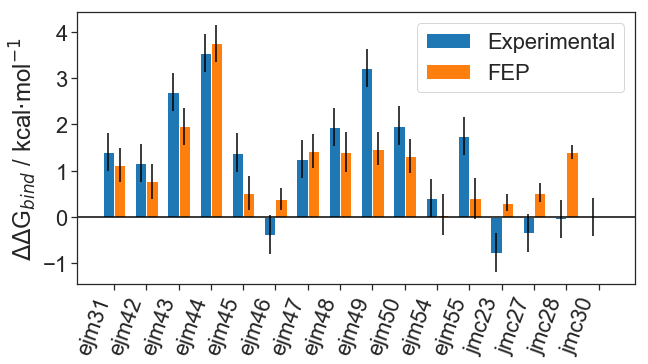

In [36]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our experimental and FEP free energies using an offset on the x position so bars don't overlap.
ax.bar(x_locs - width/2, height=freenrg_df["freenrg_exp"], width=width, yerr=freenrg_df["err_exp"],
                label='Experimental')
ax.bar(x_locs + width/2, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"],
                label='FEP')
 
# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")
plt.legend()

plt.savefig("outputs/fep_vs_exp_barplot.png", dpi=300)
plt.show()

### 3.2. Scatterplot

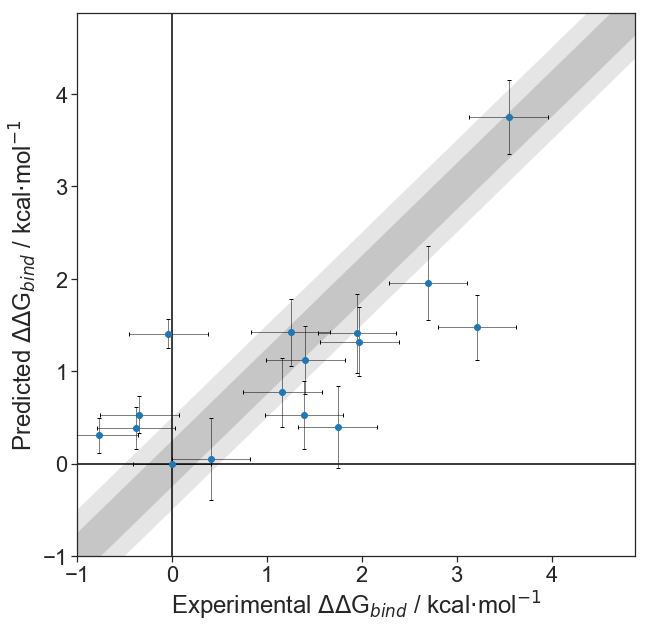

In [40]:
plt.figure(figsize=(10,10))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

# plot 1/2 kcal bounds:
plt.fill_between(
				x=[-15, 15], 
				y2=[-14.75,15.25],
				y1=[-15.25, 14.75],
				lw=0, 
				zorder=-10,
				alpha=0.3,
				color="grey")
# upper bound:
plt.fill_between(
				x=[-15, 15], 
				y2=[-14.5, 15.5],
				y1=[-14.75, 15.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-15, 15], 
				y2=[-15.5,14.5],
				y1=[-14.75, 15.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)

# plot error bars:
yerr = freenrg_df["err_fep"]
xerr = freenrg_df["err_exp"]

plt.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
            yerr=yerr,
            xerr=xerr,   # comment this line to hide experimental error bars \
                         # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# format the plot further.
plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)
plt.ylabel("Predicted $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.savefig("outputs/fep_vs_exp_scatterplot.png", dpi=300)
plt.show()

Using matplotlib, we can annotate this plot with whatever we want. For example, let's show the names of the three most outlying ligands (based on MUE).

We can construct a list of ligand names to give to matplotlib to annotate the plot with. Because this will use the coordinates of the points in the scatterplot, the number of items in the labels list must equal the number of points in the scatterplot - we can make matplotlib annotate "nothing" by feeding it an empty string ("") for points that we do not want to annotate.

In [55]:
number_outliers_to_annotate = 3

In [56]:
# get an array of the MUE values comparing experimental and FEP values. Take the absolute values.
mue_values = abs(freenrg_df["freenrg_exp"] - freenrg_df["freenrg_fep"])

# find the n ligand names that are outliers.
outlier_names = mue_values.nlargest(number_outliers_to_annotate).index.values.tolist()

# construct a list of labels to annotate the scatterplot with.
annot_labels = []
for ligand in freenrg_df.index.values:
    # if the ligand is an outlier, append the name to the annotation labels list.
    if ligand in outlier_names:
        annot_labels.append(ligand)
    else:
        # if the ligand is not an outlier, append an empty string to the annotation labels list.
        annot_labels.append("")

Now that we have our annotation labels ready, we can just repeat the plotting code while fedding matplotlib the annotations (bottom of cell).

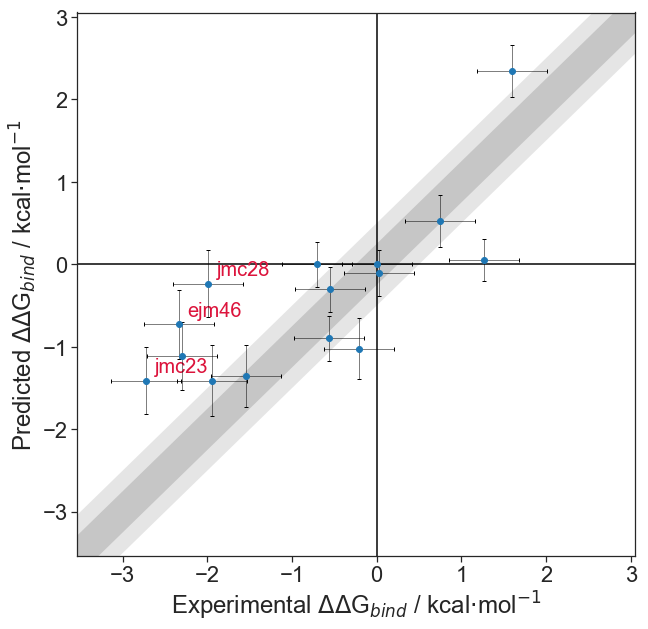

In [57]:
plt.figure(figsize=(10,10))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

# plot 1/2 kcal bounds:
plt.fill_between(
				x=[-15, 15], 
				y2=[-14.75,15.25],
				y1=[-15.25, 14.75],
				lw=0, 
				zorder=-10,
				alpha=0.3,
				color="grey")
# upper bound:
plt.fill_between(
				x=[-15, 15], 
				y2=[-14.5, 15.5],
				y1=[-14.75, 15.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-15, 15], 
				y2=[-15.5,14.5],
				y1=[-14.75, 15.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)

# plot error bars:
yerr = freenrg_df["err_fep"]
xerr = freenrg_df["err_exp"]

plt.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
            yerr=yerr,
            xerr=xerr,   # comment this line to hide experimental error bars \
                         # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# format the plot further.
plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)
plt.ylabel("Predicted $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

########## annotate.
for i, txt in enumerate(annot_labels):
    plt.annotate(txt, 
                 (freenrg_df["freenrg_exp"].values.tolist()[i]+0.1,  # x coordinates
                 freenrg_df["freenrg_fep"].values.tolist()[i]+0.1)   # y coordinates
                , size=20, color="crimson")

plt.savefig("output/fep_vs_exp_scatterplot_outliers.png", dpi=300)
plt.show()

### 3.3. Statistical analysis.
Error analysis on typical statistical measures: R, Mean Unsigned/Absolute Error (MUE) and Kendall Tau.

Below are examples of how to re-sample from the data in order to obtain error bars on correlation coefficients,
MUE and Kendall tau. Returned are confidence intervals of 65% and the median of the distribution. It is important to take these confidences into account as FEP predictions have a variance associated with them.

In [58]:
    stats = n_stats.freeEnergyStats()
    stats.generate_statistics(computed_relative_DDGs,experimental_DDGs,repeats=10000)
    r_confidence = stats.R_confidence
    tau_confidence = stats.tau_confidence
    mue_confidence = stats.mue_confidence
    print ("R confidence is:   %.2f < %.2f < %.2f" %(r_confidence[1], r_confidence[0], r_confidence[2]))
    print ("MUE confidence is: %.2f < %.2f < %.2f" %(mue_confidence[1], mue_confidence[0], mue_confidence[2]))
    print ("Tau confidence is: %.2f < %.2f < %.2f" %(tau_confidence[1], tau_confidence[0], tau_confidence[2]))

R confidence is:   0.70 < 0.73 < 0.76
MUE confidence is: 0.70 < 0.73 < 0.77
Tau confidence is: 0.48 < 0.53 < 0.57
